In [63]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

In [34]:
merged[['assoc_name_final','quarter']].head()

,assoc_name_final,quarter
3,"1 CYPRESS RUN, HOMOSASSA, FL 34446",2023-07-01
4,"10 SE KINGS BAY DR, CRYSTAL RIVER, FL 34429",2024-04-01
6,"100 THE ESPLANADE N, VENICE, FL 34285",2024-04-01
8,"101 EOLA CONDOMINIUMS ASSOCIATION, INC. 32801",2024-07-01
12,"10501 AMBERJACK WAY, ENGLEWOOD, FL 34224",2023-10-01


In [64]:
# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

In [65]:
event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)

In [23]:
#value_counts = merged['event_time'].value_counts()
#print(value_counts)

In [66]:
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

In [67]:
# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\1398399657.py:11: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0041
Estimator:                   PanelOLS   R-squared (Between):              0.0422
No. Observations:               38936   R-squared (Within):               0.0618
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0585
Time:                        17:03:49   Log-likelihood                -2.189e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      5.9194
Entities:                        5948   P-value                           0.0000
Avg Obs:                       6.5461   Distribution:                F(23,32942)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             4.5337
                            

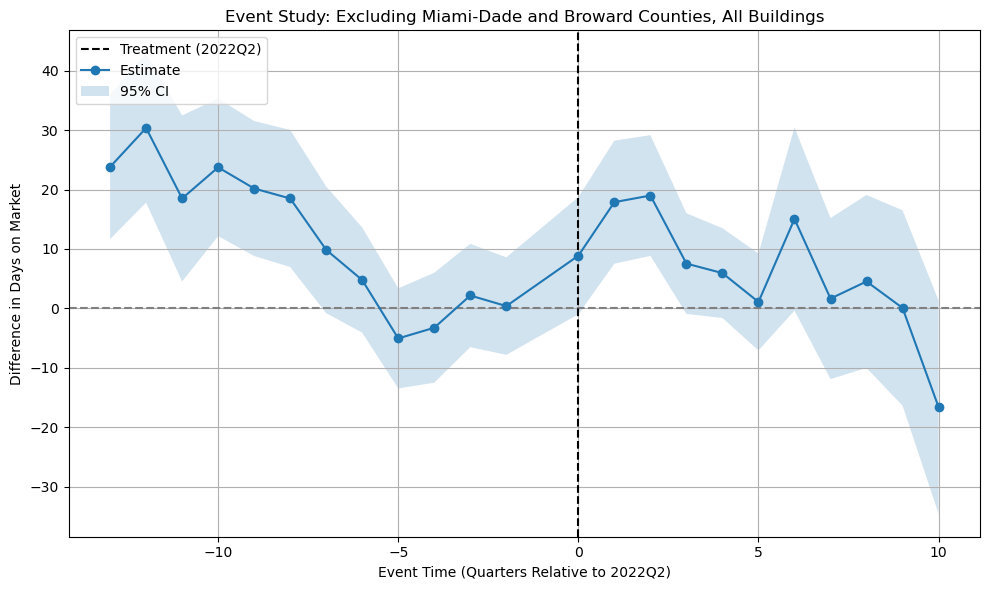

In [68]:
import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_dom/event_study_DOM_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\3337867671.py:66: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0018
Estimator:                   PanelOLS   R-squared (Between):              0.0090
No. Observations:               22296   R-squared (Within):               0.0221
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0186
Time:                        17:04:00   Log-likelihood                -1.235e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.4595
Entities:                        4061   P-value                           0.0718
Avg Obs:                       5.4903   Distribution:                F(23,18189)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.1679
                            

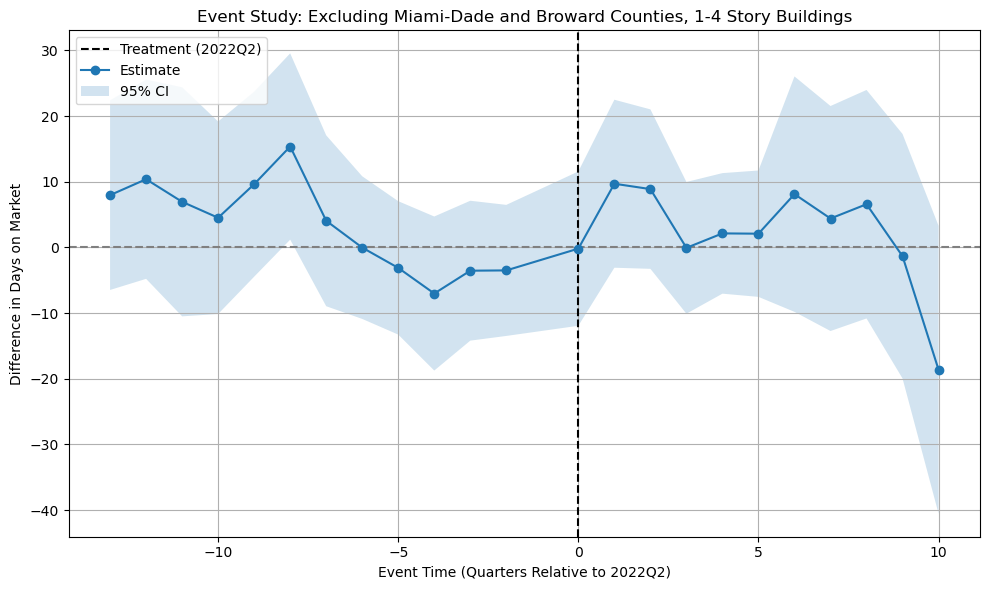

In [69]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_dom/event_study_DOM_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\2354983316.py:66: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0026
Estimator:                   PanelOLS   R-squared (Between):             -0.0067
No. Observations:               13449   R-squared (Within):              -0.0132
Date:                Wed, Jul 23 2025   R-squared (Overall):             -0.0133
Time:                        17:04:08   Log-likelihood                -7.678e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2503
Entities:                        2246   P-value                           0.1889
Avg Obs:                       5.9880   Distribution:                F(23,11157)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.1789
                            

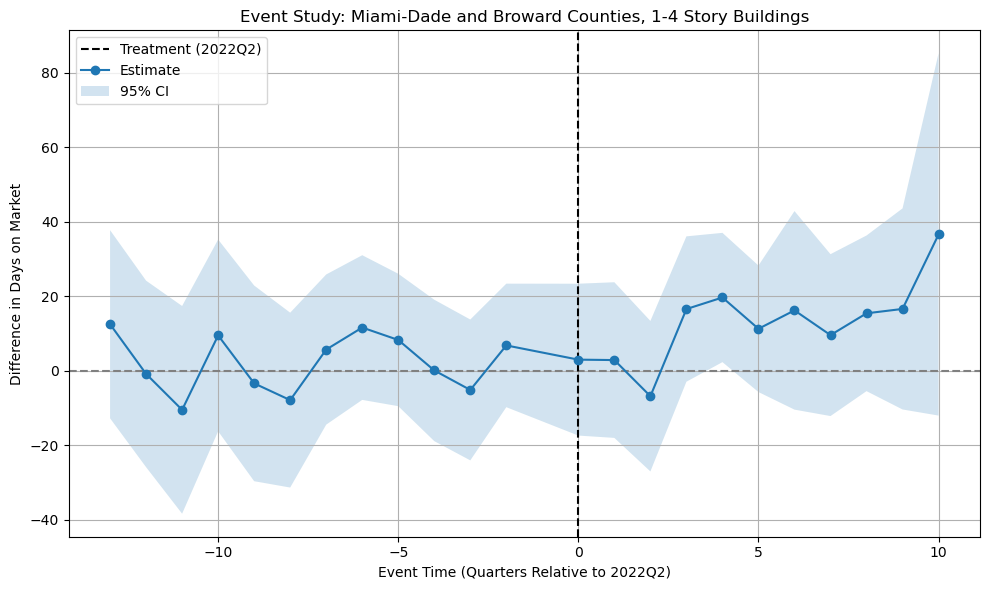

In [70]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_dom/event_study_DOM_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\2168514702.py:66: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0031
Estimator:                   PanelOLS   R-squared (Between):              0.0408
No. Observations:               29766   R-squared (Within):               0.0774
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0675
Time:                        17:04:16   Log-likelihood                -1.731e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.5695
Entities:                        3563   P-value                           0.0000
Avg Obs:                       8.3542   Distribution:                F(23,26157)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             2.4662
                            

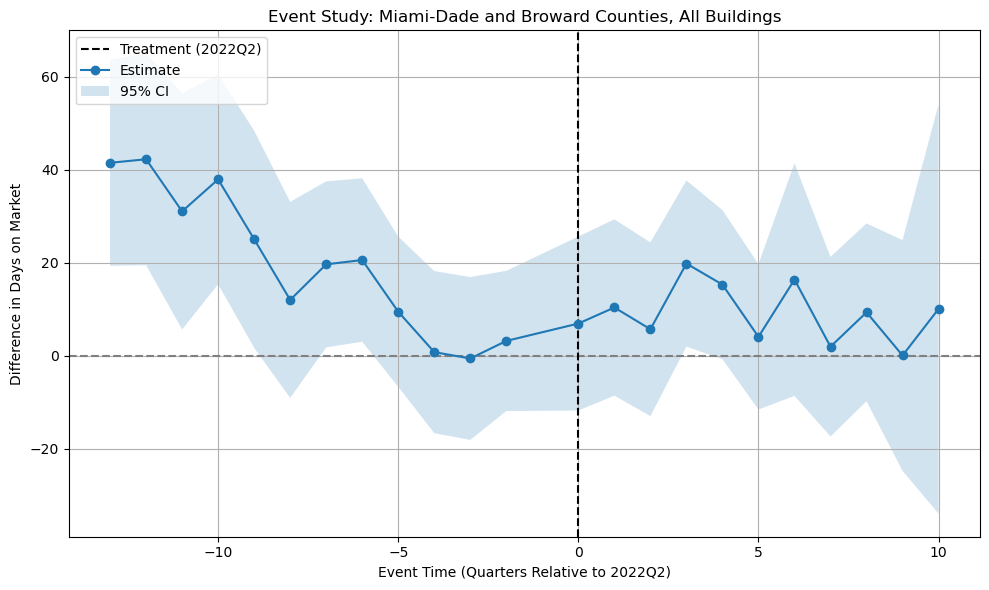

In [71]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_dom/event_study_DOM_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0201
Estimator:                   PanelOLS   R-squared (Between):             -0.0491
No. Observations:               26852   R-squared (Within):               0.0810
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0966
Time:                        17:04:22   Log-likelihood                -1.585e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.772
Entities:                         114   P-value                           0.0000
Avg Obs:                       235.54   Distribution:                F(37,26678)
Min Obs:                       2.0000                                           
Max Obs:                       1985.0   F-statistic (robust):             20.330
                            

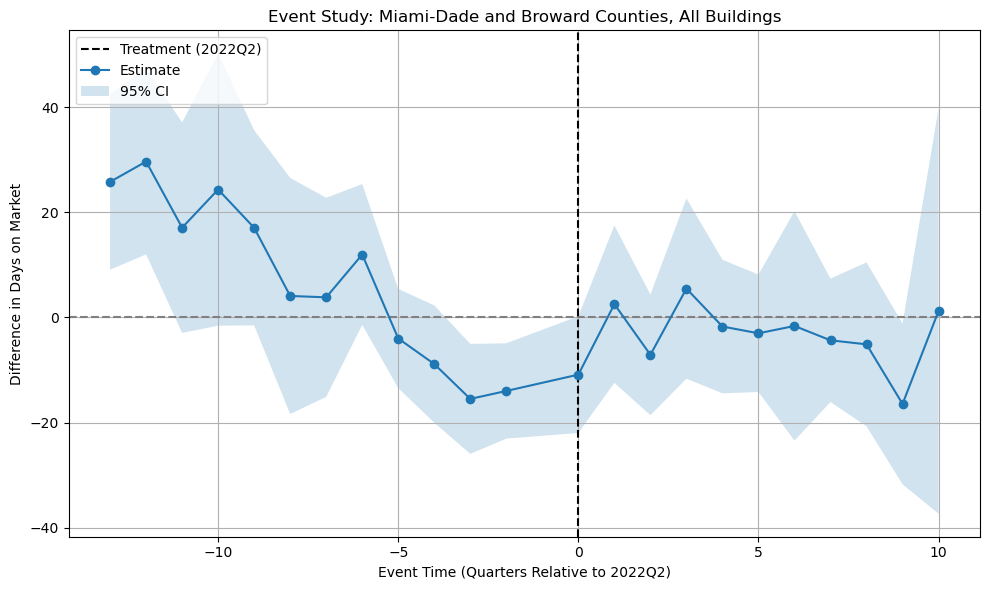

In [72]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_dom/event_study_DOM_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0061
Estimator:                   PanelOLS   R-squared (Between):              0.0075
No. Observations:               12629   R-squared (Within):               0.0006
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0112
Time:                        17:04:31   Log-likelihood                -7.358e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.0823
Entities:                         109   P-value                           0.0001
Avg Obs:                       115.86   Distribution:                F(37,12460)
Min Obs:                       2.0000                                           
Max Obs:                       1041.0   F-statistic (robust):             6.7004
                            

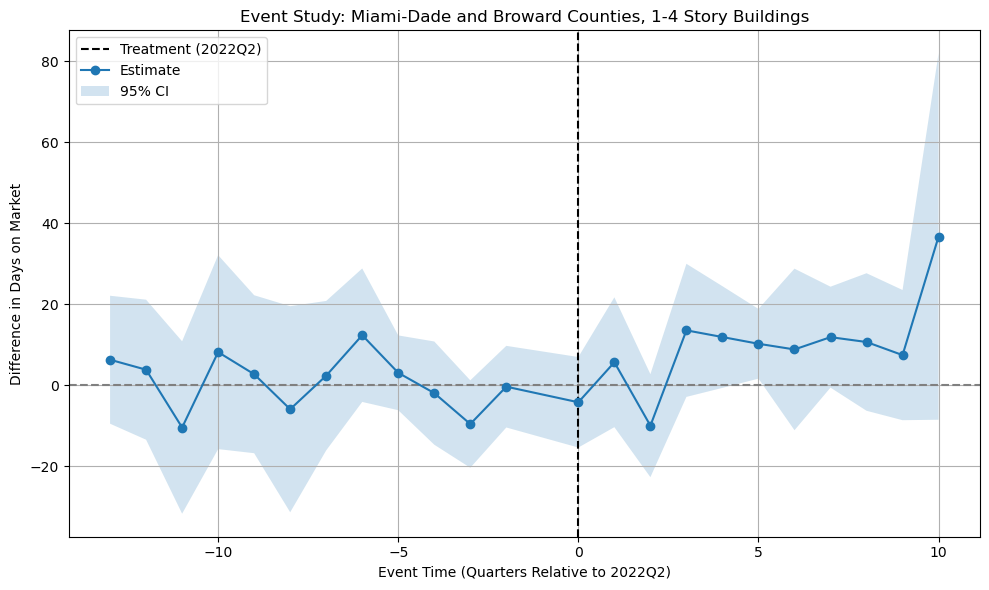

In [73]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_dom/event_study_DOM_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0079
Estimator:                   PanelOLS   R-squared (Between):             -0.0178
No. Observations:               30204   R-squared (Within):               0.0538
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0513
Time:                        17:04:37   Log-likelihood                -1.727e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.3820
Entities:                         392   P-value                           0.0000
Avg Obs:                       77.051   Distribution:                F(37,29752)
Min Obs:                       1.0000                                           
Max Obs:                       559.00   F-statistic (robust):             4.6643
                            

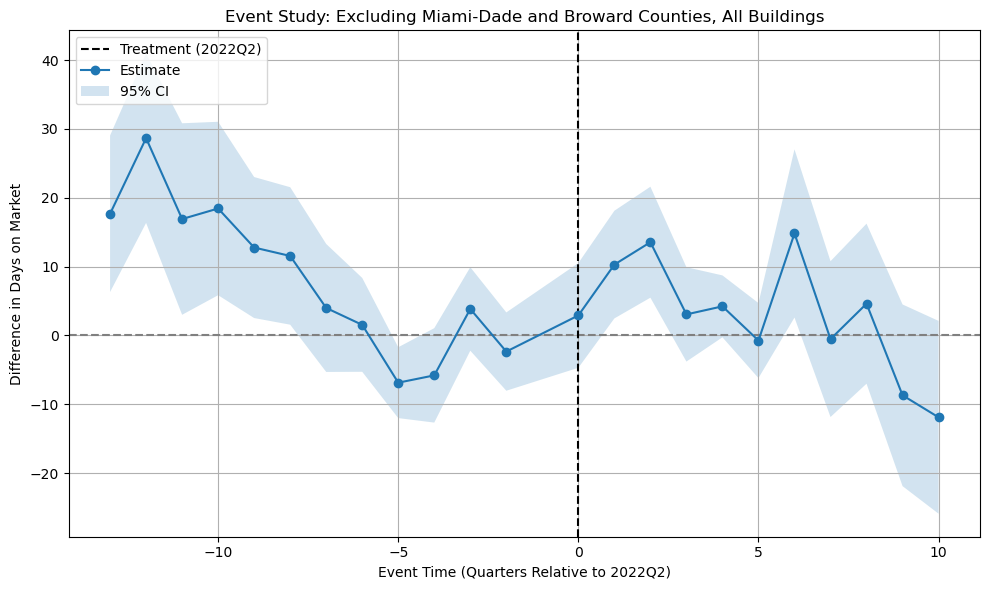

In [74]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_dom/event_study_DOM_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0064
Estimator:                   PanelOLS   R-squared (Between):              0.0027
No. Observations:               16978   R-squared (Within):               0.0199
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0220
Time:                        17:04:45   Log-likelihood                -9.585e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      2.8756
Entities:                         379   P-value                           0.0000
Avg Obs:                       44.797   Distribution:                F(37,16539)
Min Obs:                       1.0000                                           
Max Obs:                       377.00   F-statistic (robust):             2.7538
                            

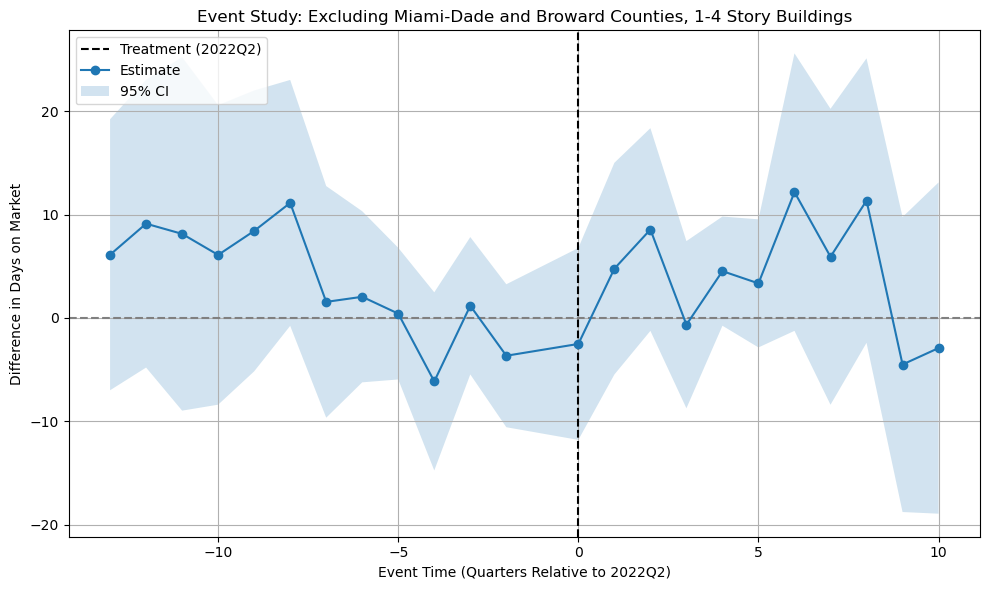

In [75]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_dom/event_study_DOM_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\429111004.py:66: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0026
Estimator:                   PanelOLS   R-squared (Between):             -0.0084
No. Observations:               13449   R-squared (Within):              -0.0132
Date:                Wed, Jul 23 2025   R-squared (Overall):             -0.0111
Time:                        17:04:53   Log-likelihood                -7.678e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.2503
Entities:                        2246   P-value                           0.1889
Avg Obs:                       5.9880   Distribution:                F(23,11157)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             1.1789
                            

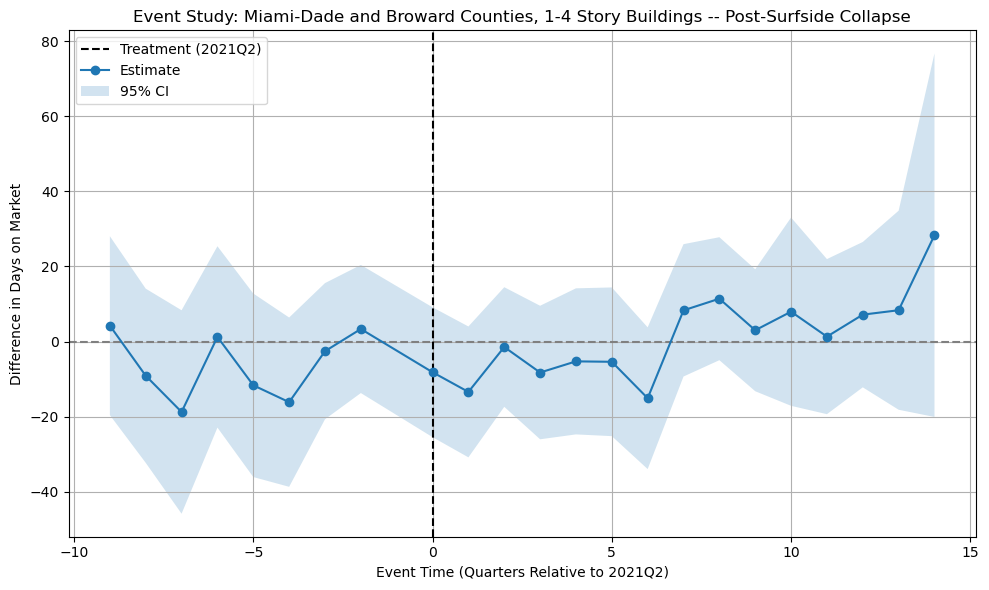

In [76]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_dom/assoc_fe/event_study_surfside_DOM_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_27324\27969640.py:66: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0031
Estimator:                   PanelOLS   R-squared (Between):              0.0284
No. Observations:               29766   R-squared (Within):               0.0774
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0660
Time:                        17:05:01   Log-likelihood                -1.731e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3.5695
Entities:                        3563   P-value                           0.0000
Avg Obs:                       8.3542   Distribution:                F(23,26157)
Min Obs:                       1.0000                                           
Max Obs:                       25.000   F-statistic (robust):             2.4662
                            

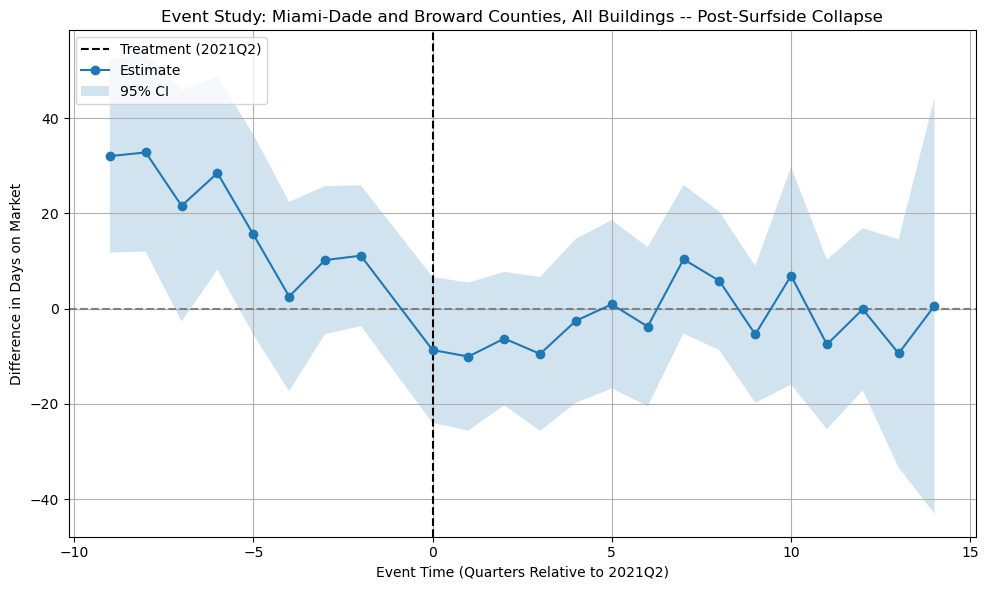

In [77]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_dom/assoc_fe/event_study_surfside_DOM_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0047
Estimator:                   PanelOLS   R-squared (Between):             -0.0138
No. Observations:               13449   R-squared (Within):               0.0012
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0061
Time:                        17:05:07   Log-likelihood                -7.834e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1.8527
Entities:                         110   P-value                           0.0018
Avg Obs:                       122.26   Distribution:                F(34,13282)
Min Obs:                       2.0000                                           
Max Obs:                       1059.0   F-statistic (robust):             5.8777
                            

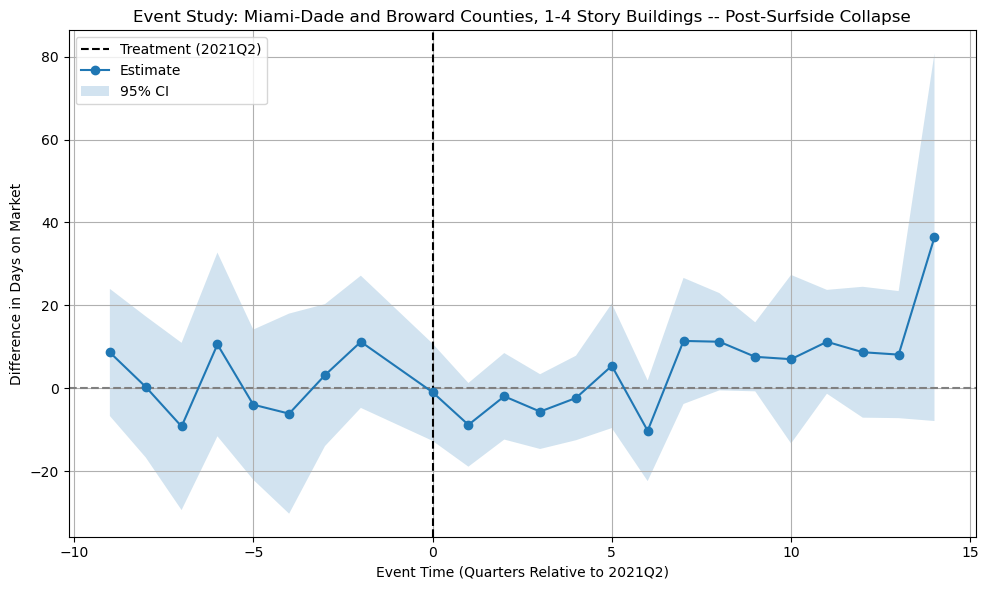

In [78]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_dom/zip_fe/event_study_surfside_DOM_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:          dom_assoc_qtr   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):             -0.1866
No. Observations:               29766   R-squared (Within):               0.0906
Date:                Wed, Jul 23 2025   R-squared (Overall):              0.0943
Time:                        17:05:16   Log-likelihood                -1.761e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      14.057
Entities:                         115   P-value                           0.0000
Avg Obs:                       258.83   Distribution:                F(34,29594)
Min Obs:                       2.0000                                           
Max Obs:                       2333.0   F-statistic (robust):             15.222
                            

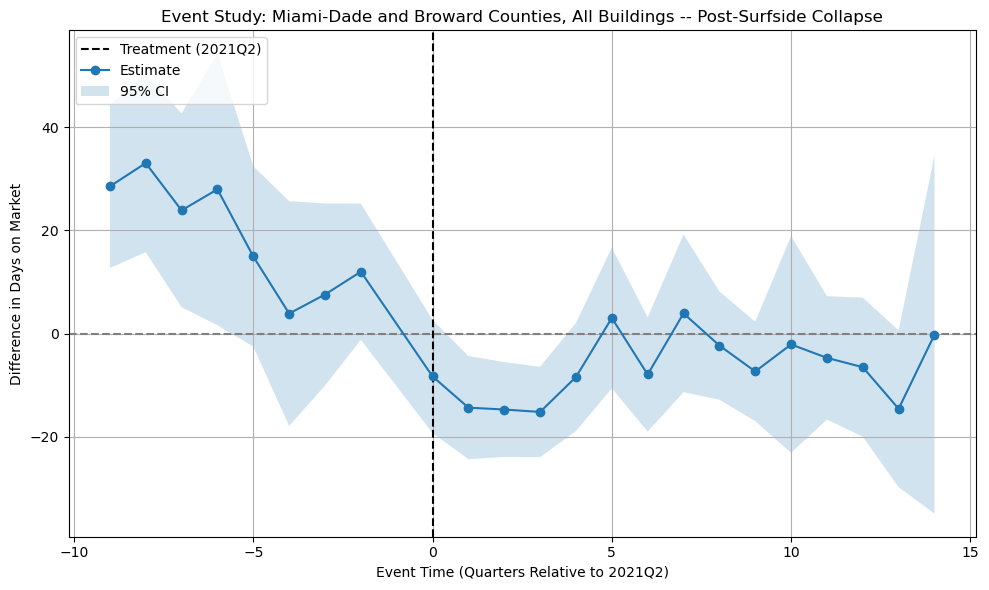

In [79]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['dom_assoc_qtr']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Days on Market')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_dom/zip_fe/event_study_surfside_DOM_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()